In [1]:
%load_ext autoreload
%autoreload 2

import requests
import torch
from torch.utils.data import DataLoader
import random
import torch.nn as nn 
from torch import optim
# from sklearn.decomposition import TruncatedSVD as svds
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pad_sequence
from spice import SpiceEmbeddingModel
from gru import GRUEncoder, GRUDecoder
from matplotlib import pyplot as plt
from time import time 

# Spice encoding 

In [2]:


URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
FILE_PATH = "shakespeare.txt"
EMB_DIM = 64
WINDOW = 5


try:
    with open(FILE_PATH, 'r', encoding='utf-8') as f:
        text = f.read()
except FileNotFoundError:
    response = requests.get(URL)
    text = response.text
    with open(FILE_PATH, 'w', encoding='utf-8') as f:
        f.write(text)


spice_model = SpiceEmbeddingModel(emb_dim=50, window_size=3)

sentences = spice_model.preprocess_text(text)
# print(sentences)


dataset = spice_model.get_dataset(text)
# spice_model.save_model(spice_model.embeddings)

dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


# for batch in dataloader:
#     sentence_embeddings = batch
#     print("Sentence Embeddings: ", len(sentence_embeddings[0]))



/home/baptiste/Documents/cours/projet_3A/TPDN_text/spice.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor([self.embeddings[self.word2idx[word]] for word in sentence.split() if word in self.word2idx], dtype=torch.float32)


# Modèle definition

Epoch 1/50, Loss: 0.008091472056218085
Epoch 2/50, Loss: 0.00720412815942175
Epoch 3/50, Loss: 0.006661063109111803
Epoch 4/50, Loss: 0.006101224775193259
Epoch 5/50, Loss: 0.005612881930904801
Epoch 6/50, Loss: 0.005170348186352799
Epoch 7/50, Loss: 0.004751137149551968
Epoch 8/50, Loss: 0.004420683533350133
Epoch 9/50, Loss: 0.004142753687285056
Epoch 10/50, Loss: 0.003913338096357289
Epoch 11/50, Loss: 0.0037038782055870715
Epoch 12/50, Loss: 0.0035190903575064362
Epoch 13/50, Loss: 0.0033610278908533723
Epoch 14/50, Loss: 0.0032153782297179782
Epoch 15/50, Loss: 0.0030890859402874908
Epoch 16/50, Loss: 0.002968452309274157
Epoch 17/50, Loss: 0.002863020579917991
Epoch 18/50, Loss: 0.002767479848857461
Epoch 19/50, Loss: 0.0026771431108830834
Epoch 20/50, Loss: 0.0025949783184015278
Epoch 21/50, Loss: 0.0025226249900614757
Epoch 22/50, Loss: 0.0024579088534334337
Epoch 23/50, Loss: 0.002397646086385728
Epoch 24/50, Loss: 0.002338207174695774
Epoch 25/50, Loss: 0.002283974651866381
E

[]

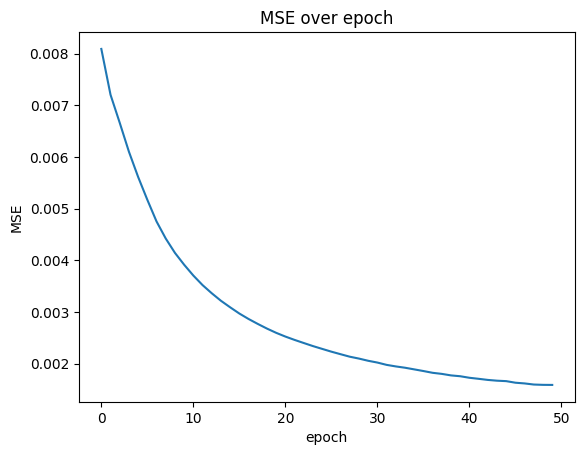

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(batch):
    """ permet de rajouter du padding et renvoyer la taille de la séquence dans un batch"""
    batch = [item for item in batch if len(item) > 0]  # Filtrer les séquences vides
    lengths = torch.tensor([len(seq) for seq in batch])  # Longueurs originales
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=0.0)  # Padding des séquences
    return padded_batch, lengths


spice_model = SpiceEmbeddingModel()
spice_model.load_model()
dataset = spice_model.get_dataset(text)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

input_size = 50 # taille des embeddings
hidden_size = 128
lr = 0.001
num_layer=3
num_epochs = 50

encoder = GRUEncoder(input_size, hidden_size, num_layer).to(device)
decoder = GRUDecoder(hidden_size, input_size, num_layer).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) +list(decoder.parameters()), lr=lr)

losses = []
t0 = time()
for epoch in range(num_epochs):
    total_loss = 0.0

    for batch, lengths in dataloader:
        batch = batch.to(device)
        lengths = lengths.to(device)
        optimizer.zero_grad()

        encoded, perm_idx = encoder(batch, lengths)
        reconstructed = decoder(encoded, lengths)
        
        # Remettre les séquences dans l'ordre original
        _, reverse_idx = perm_idx.sort()
        reconstructed = reconstructed[reverse_idx]
        batch = batch[reverse_idx]

        # Calcul de la perte (ignorer le padding)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss/ len(dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")
t1 = time()
torch.save(encoder, "encoder.pth")
torch.save(decoder, "decoder.pth")
print( f"training time : {t1-t0}")
plt.plot(losses)
plt.title("MSE over epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot()


In [12]:


def decode_sequence(spice_model, sequence):
    """decode les embeddings en mots"""
    decoded_words = []
    for embedding in sequence.cpu():
        if embedding.sum() != 0:  # Ignorer le padding
            decoded_words.append(spice_model.decode_embedding(embedding.detach().numpy(), top_n=1)[0])
    return " ".join(decoded_words)

batch, lengths = next(iter(dataloader))  
idx = random.randint(0, batch.size(0) - 1)  #  phrase au hasard
input_seq = batch[idx].unsqueeze(0).to(device)  # le tenseur avec du padding
mask = (input_seq != 0).any(dim=2)  # vérifie si chaque ligne contient des valeurs non nulles
tensor_clean = input_seq[:, mask[0], :] # enlève les vecteurs nuls du padding
length = torch.tensor([tensor_clean.shape[1]]).to(device)  # récupère la longueur originale sans le padding


encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded, _ = encoder(input_seq, length)
    reconstructed_seq = decoder(encoded, length)


original_text = decode_sequence(spice_model, input_seq.squeeze(0))
reconstructed_text = decode_sequence(spice_model, reconstructed_seq.squeeze(0))


print(f"originale**: {original_text}")
print(f"reconstruite**: {reconstructed_text}")


originale**: to this submission yet i well remember
reconstruite**: to this submission me i will for


# test
